In [4]:

import os
import shutil
import subprocess
import time

import gymnasium as gym
import imageio
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import tqdm
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.logger import Video
import tensorboard

from utils import gauss, gaussp, inv_hea, hea, porte

In [5]:

class CustomRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super(CustomRewardWrapper, self).__init__(env)

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        # Access relevant state and action variables
        
        #state
        mapping = {"z": 0, "a": 1, "a_hip": 2, "a_knee": 3, "a_ankle": 4, "v_x": 5, "v_z": 6, "a_d": 7, "a_hip_d": 8, "a_knee_d": 9, "a_ankle_d": 10}
        z = obs[0]                  # z of the robot
        a = obs[1]                  # Angle of the robot
        a_hip = obs[2]              # Angle of the hip
        a_knee = obs[3]             # Angle of the knee
        a_ankle = obs[4]            # Angle of the ankle
        v_x = obs[5]                # Velocity in x direction
        v_z = obs[6]                # Velocity in z direction
        a_d = obs[7]                # Angular velocity 
        a_hip_d = obs[8]            # Angular velocity of the hip
        a_knee_d = obs[9]           # Angular velocity of the knee
        a_ankle_d = obs[10]         # Angular velocity of the ankle
        
        #action
        torque_hip = action[0]      # Torque applied to the hip
        torque_knee = action[1]     # Torque applied to the knee
        torque_ankle = action[2]    # Torque applied to the ankle

        energy_used = np.sum(np.square(action))  # Simplistic energy calculation
        energy_kin = (a_d**2 + a_hip_d**2 + a_knee_d**2 + a_ankle_d**2 + v_x**2 + v_z**2)

        # Custom reward logic
        get_straight = gauss(z, 1.2, 0.3*1.2) * gauss(a, -2*np.pi, 0.30*2*np.pi) * gauss(a_hip, 0, 0.30*2*np.pi) * gauss(a_knee, 0, 0.30*2*np.pi) * gauss(a_ankle, 0, 0.30*2*np.pi)
        vel_flip = - 2 * torque_hip * a_hip + torque_knee * a_knee + torque_ankle * a_ankle
        
        flipping = - a_d * (1.0 + 18 * z + .6 * vel_flip - .8 * v_x) - 15 * abs(a_hip)
        landing = 5e2 * get_straight #huge reward for good landing
        
        if -a > 2 * np.pi - np.pi/3 and -a <  2 * np.pi + np.pi/3:
            flipping = 0
            landing *= (1 - max(1, landing/(.9 * energy_kin + 9e1 * energy_used)))
        
        bonus = 500
        conds = [z > 0.95, -a > 2 * np.pi - np.pi/3, -a <  2 * np.pi + np.pi/3]
        if all(conds):
            flipping = 0
            landing += bonus
            
        custom_reward = 0
        custom_reward += landing
        custom_reward += flipping
        
        # attributes for monitoring
        self.vel_act = vel_flip
        self.get_straight = get_straight
        self.landing = landing
        self.flipping = flipping

        if done:
            custom_reward -= 5e3  # Heavy penalty for falling
        return obs, custom_reward, done, truncated, info  
    
class VideoRecorderCallback(BaseCallback):
    def __init__(self, eval_env: gym.Env, render_freq: int, n_eval_episodes: int = 1, deterministic: bool = True):
        """
        Records a video of an agent's trajectory traversing ``eval_env`` and logs it to TensorBoard

        :param eval_env: A gym environment from which the trajectory is recorded
        :param render_freq: Render the agent's trajectory every eval_freq call of the callback.
        :param n_eval_episodes: Number of episodes to render
        :param deterministic: Whether to use deterministic or stochastic policy
        """
        super().__init__()
        self._eval_env = eval_env
        self._render_freq = render_freq
        self._n_eval_episodes = n_eval_episodes
        self._deterministic = deterministic

    def _on_step(self) -> bool:
        if self.n_calls % self._render_freq == 0:
            screens = []

            def grab_screens(_locals, _globals) -> None:
                """
                Renders the environment in its current state, recording the screen in the captured `screens` list

                :param _locals: A dictionary containing all local variables of the callback's scope
                :param _globals: A dictionary containing all global variables of the callback's scope
                """
                screen = self._eval_env.render()
                # PyTorch uses CxHxW vs HxWxC gym (and tensorflow) image convention
                screens.append(screen.transpose(2, 0, 1))

            evaluate_policy(
                self.model,
                self._eval_env,
                callback=grab_screens,
                n_eval_episodes=self._n_eval_episodes,
                deterministic=self._deterministic,
            )
            self.logger.record(
                "video render",
                value=Video(th.from_numpy(np.asarray([screens])), fps=50),
                exclude=("stdout", "log", "json", "csv"),
            )
        return True

In [6]:
folder = '/home/killian/Documents/code/hopper'
d = time.strftime("%Y-%m-%d_%H-%M-%S")

healthy_reward = 1
healthy_z_range = (0.2, 1.25)
healthy_angle_range = (-float("inf"), float("inf"))
reset_noise_scale = 5e-3
n_learning_steps = 5_000_000

env = gym.make('Hopper-v4', render_mode='rgb_array', healthy_reward=healthy_reward, healthy_z_range=healthy_z_range, healthy_angle_range=healthy_angle_range, reset_noise_scale=reset_noise_scale)

video_recorder = VideoRecorderCallback(env, render_freq=50_000)
env = CustomRewardWrapper(env)

model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="../Tensorboard/")

model_load = False
d_load = "2024-08-14_17-41-23"
n_learning_steps_load = 1_000_000
if model_load:
    d = d_load
    env.reset()
    file = folder + "/Model/hopper_model_%s"%d
    model = PPO.load(file, env=env, verbose=1, tensorboard_log="../Tensorboard/")
    model.learn(total_timesteps=n_learning_steps_load, callback=video_recorder, tb_log_name=d)
else:
    model.learn(total_timesteps=n_learning_steps, callback=video_recorder, tb_log_name=d)

# Save the model
model.save(folder + "/Model/hopper_model")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ../Tensorboard/2024-08-15_15-04-59_1
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 132       |
|    ep_rew_mean     | -5.56e+03 |
| time/              |           |
|    fps             | 2214      |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 106          |
|    ep_rew_mean          | -3.9e+03     |
| time/                   |              |
|    fps                  | 981          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0063955216 |
|    clip_fraction        | 0.0504 

Episode finished after 222 timesteps


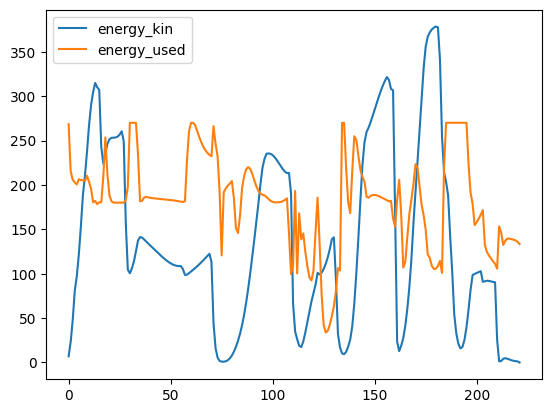

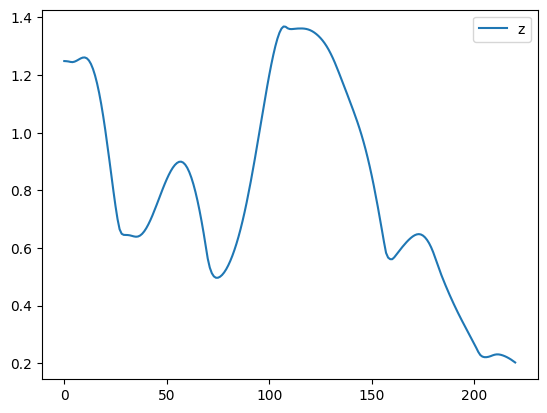

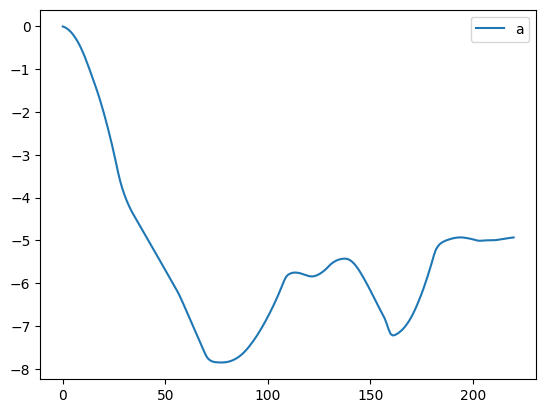

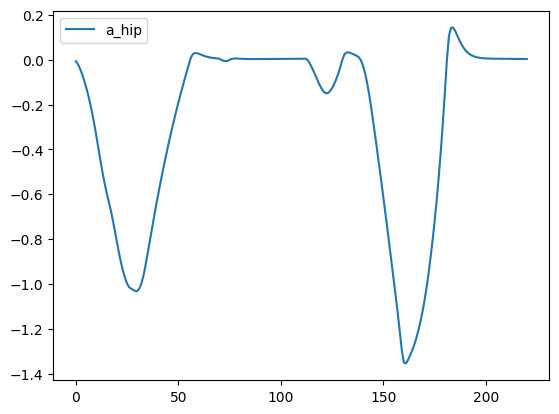

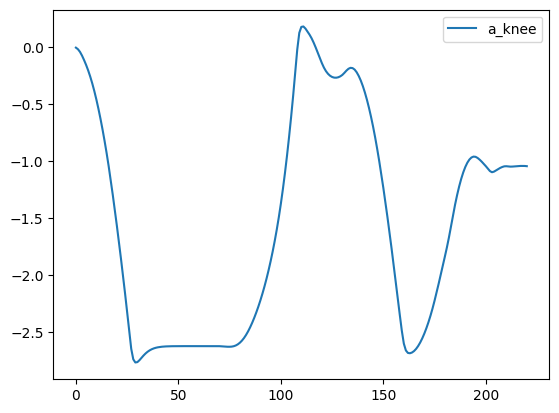

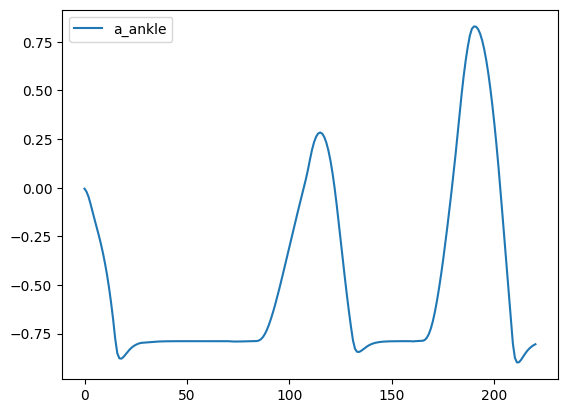

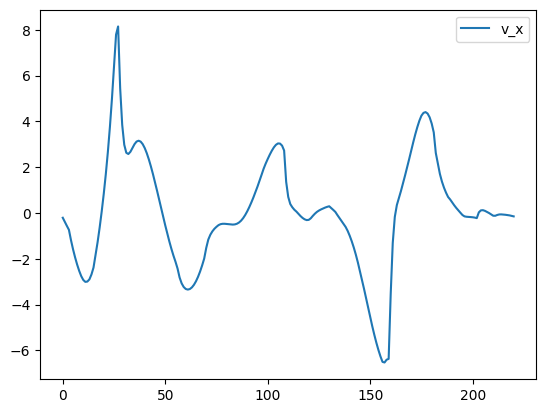

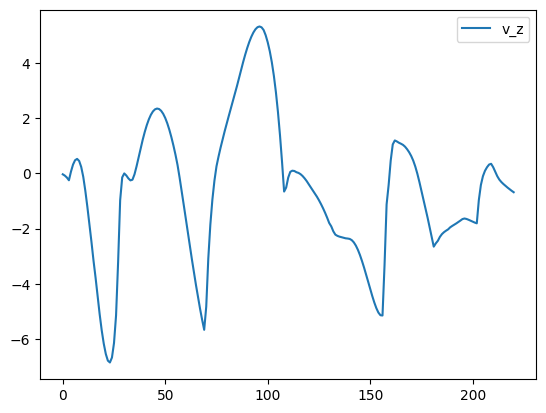

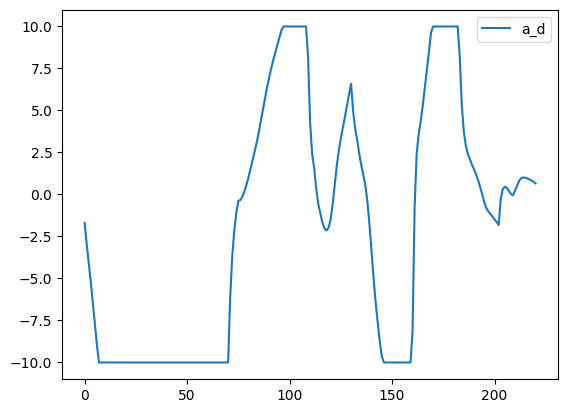

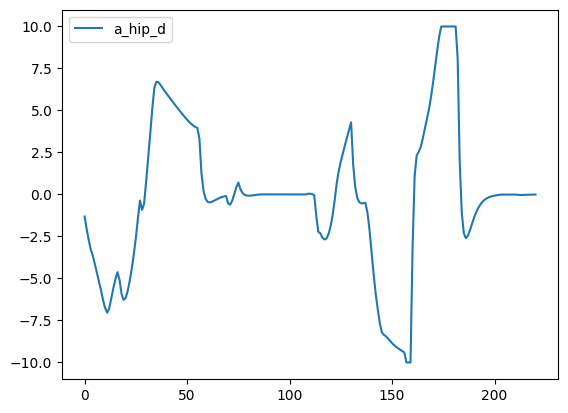

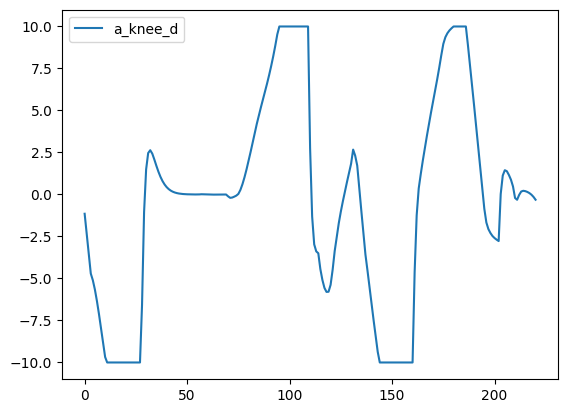

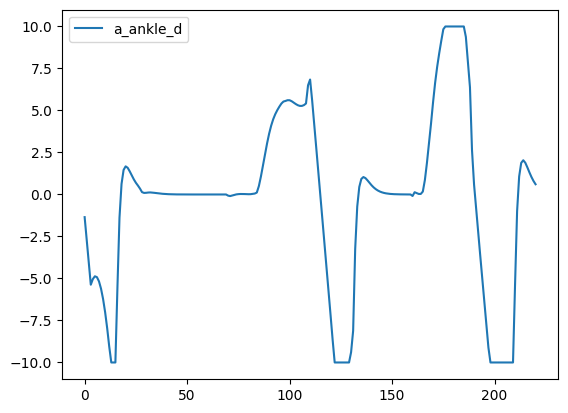

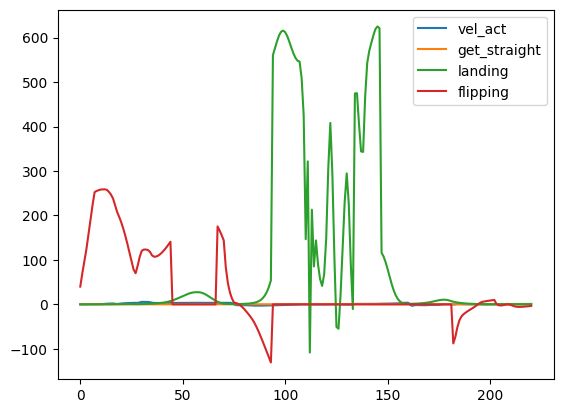

In [ ]:
vec_env = model.get_env()
obs = vec_env.reset()

# Action and observation mapping
mapping = {"z": 0, "a": 1, "a_hip": 2, "a_knee": 3, "a_ankle": 4, "v_x": 5, "v_z": 6, "a_d": 7, "a_hip_d": 8, "a_knee_d": 9, "a_ankle_d": 10}

# Set up video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('hopper-flip.mp4', fourcc, 50, (480, 480))

N_step = 1000
s_a = np.zeros((N_step, 14))  # 11 states + 3 actions
rwd = np.zeros((N_step, 4))   # vel_act, get_straight, landing, flipping

energy_kin = []
energy_used = []

for i in range(N_step):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
    img = vec_env.render(mode='rgb_array')
    
    energy_kin.append(obs[0][5]**2 + obs[0][6]**2 + obs[0][7]**2 + obs[0][8]**2 + obs[0][9]**2 + obs[0][10]**2)
    energy_used.append(np.sum(np.square(action)))
    
    # Convert RGB to BGR for OpenCV compatibility
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    out.write(img)
    
    s_a[i, :] = np.concatenate((obs[0], action[0]))
    rwd[i, :] = [env.vel_act, env.get_straight, env.landing, env.flipping]
    
    if done:
        N_stop = i
        print(f"Episode finished after {i+1} timesteps")
        break
        obs = vec_env.reset()

out.release()

plt.figure("energy_kin")
plt.plot(0.9 * np.array(energy_kin), label="energy_kin")
plt.plot(90 * np.array(energy_used), label="energy_used")
plt.legend()
plt.show()

# Truncate the arrays to only include the steps before termination
s_a = s_a[:N_stop, :]
rwd = rwd[:N_stop, :]

# Plotting function
def plot(map: str="z"):
    plt.figure()
    plt.plot(s_a[:, mapping[map]], label=map)
    plt.legend()
    plt.show()

# Plot all observations
for key in mapping.keys():
    plot(key)

# Plot rewards
plt.figure("reward")
plt.plot(rwd[:, 0], label="vel_act")
plt.plot(rwd[:, 1], label="get_straight")
plt.plot(rwd[:, 2], label="landing")
plt.plot(rwd[:, 3], label="flipping")
plt.legend()
plt.show()

In [ ]:

#folder = 'c:/Users/killi/Documents/code/Hopper-4-flip'
folder = '/home/killian/Documents/code/hopper'

save_folders = ['/Model', '/Tensorboard', '/Render', '/Run']
for save_folder in save_folders:
    try: 
        os.mkdir(folder + save_folder)
    except:
        pass
    
shutil.copyfile('hopper.ipynb', folder + '/Run/hopper_%s.ipynb'%(d))
shutil.copyfile('hopper-flip.mp4', folder + '/Render/hopper-flip_%s.mp4'%(d))
shutil.copyfile('hopper_model.zip', folder + '/Model/hopper_model_%s.zip'%(d))

'/home/killian/Documents/code/hopper/Model/hopper_model_2024-08-15_12-59-21.zip'